___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [30]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from skimage.metrics import structural_similarity as ssim
import tifffile 

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [16]:
from fontsetting import font_cmu
plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [17]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cpu


___
### Read training data from `data/train-clean-tif`


In [37]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)

Number of images in the dataset: 52


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [38]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [39]:
# DENOISE
class Denoise1(nn.Module):
    def __init__(self):
        super(Denoise1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d((2,2),2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2),2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2),2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2),2))
        
        self.relu   = nn.ReLU()
        self.convT1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.convT2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.convT3 = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)
        self.convT4 = nn.ConvTranspose2d(3, 3, kernel_size=3, padding=1)
       
        self.up = nn.Upsample(scale_factor = 16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        print(self.convT1)
        x = self.convT1(x)
        x = self.relu(self.convT2(x))
        x = self.relu(self.convT3(x))
        x = self.up(x)
        x = self.relu(self.convT4(x))
        x = self.relu(x)
        return x

In [7]:
# DENOISE
class Denoise2(nn.Module):
    def __init__(self):
        super(Denoise2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=(7,7), padding=3, stride=1),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
            nn.ReLU())

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(7,7), padding=3, stride=1),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=(7,7), padding=3, stride=1))

        self.conv6 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1, stride=1))

        self.conv7 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(7,7), padding=3, stride=1),
            nn.BatchNorm1d(??),
            nn.ReLU())



        


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.conv6(x)

        
        
        return x

In [40]:
class MihirDN(nn.Module): #MIHIR
  def __init__(self):
    super(MihirDN, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    # Rest of the layers remain the same
    self.conv2 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
    self.conv3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU())
    self.conv4 = nn.Sequential(
      nn.Conv2d(128, 1, kernel_size=3, padding=1),
      nn.ReLU())
    self.up = nn.Upsample(scale_factor=4)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.up(x)
    x = self.conv4(x)
    return x

___
### Define NMSE and SSIM Function

In [41]:
def calcNMSE(clean, denoised):
    mse  =  torch.mean((clean - denoised)**2)
    nmse = mse / torch.mean(clean**2)
    return nmse.detach().item()

def calcSSIM(true_img, noisy_img):
    true_img  = np.abs(true_img.detach()).squeeze().numpy()
    noisy_img = np.abs(noisy_img.detach()).squeeze().numpy()
    img_range = np.max(true_img) - np.min(true_img)

    # Determine the smaller side of the images
    min_size = min(true_img.shape)
    if min_size % 2 == 0:
        min_size -= 1
    # Calculate an appropriate window size
    
    win_size = min(7, min_size)
    print(win_size)

    return ssim(true_img, noisy_img, data_range=img_range)
    

___
### Create a function to execute training. Note, we will call this function later.

In [42]:
def train_model(model, opt, criterion, train_loader, num_epoch, noise_std):
    avg_train_losses = []

    for epoch in range(num_epoch): # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0
        for i, y_tr_batch in enumerate(train_loader): # Loop over mini-batches
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = y_tr_batch + noise

            opt.zero_grad() # delete previous gradients
            y_hat_tr_batch = model(x_tr_batch) # forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch) # compute loss
            loss.backward() # backward pass
            opt.step() # update weights
            total_train_loss += loss.item() # accumulate loss
            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader) # compute average loss
        avg_train_losses.append(avg_train_loss) # accumulate average loss

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch+1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Set the vertical axis to log scale
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


c:\Users\demaa\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1, 256, 256])) that is different to the input size (torch.Size([2, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Epoch 1, Iteration 10, Loss: 0.054274
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), strid

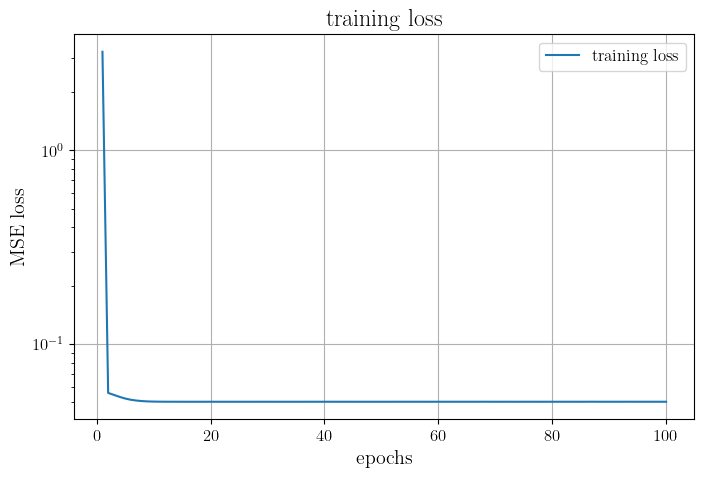

In [63]:
batch_size = 2  # Number of complete images in each batch
lr = 1e-2  # Learning rate
sig = 0.1  # Noise std
num_epoch = 100  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)

model = Denoise1() # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
train_model(model, opt, criterion, train_loader, num_epoch, noise_std=sig)

___
### Apply it to one of the validation image

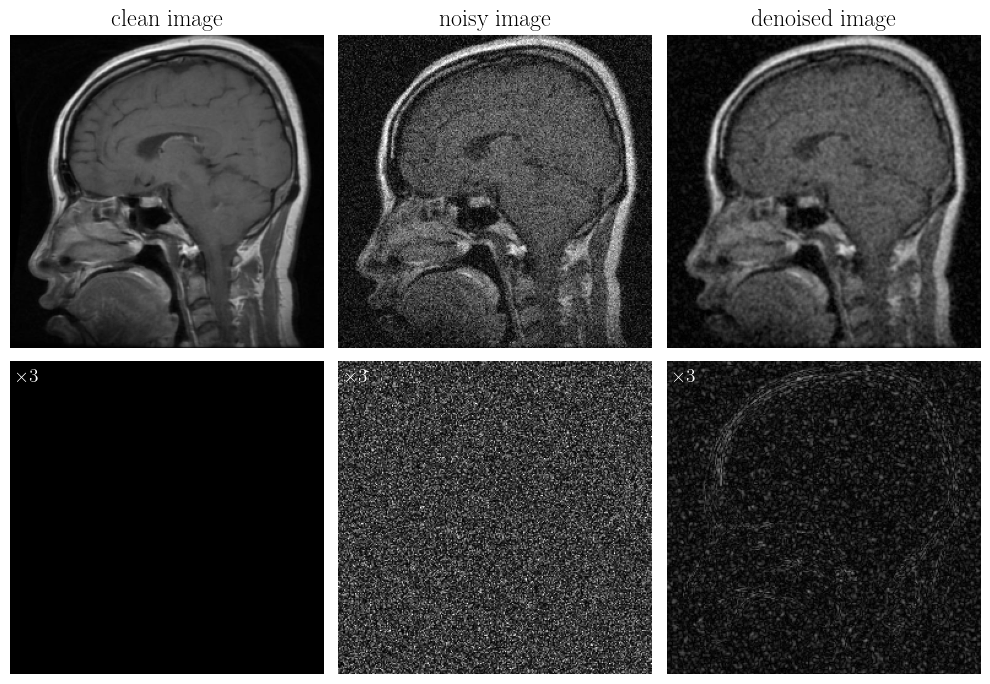

In [62]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')


plt.tight_layout()
plt.show()


In [59]:
calcNMSE(val_clean, val_denoised)

0.018051719292998314

In [60]:
calcSSIM(val_clean, val_denoised)

7


0.7031770432148352

In [47]:
val_denoised.shape

torch.Size([1, 256, 256])

In [48]:
val_clean.shape

torch.Size([1, 256, 256])